In [ ]:
!pip install git+https://github.com/fastai/fastcore > /dev/null
!pip install git+https://github.com/fastai/fastai2 > /dev/null
!pip install iterative-stratification > /dev/null
!pip install timm -U

https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/05_EfficientNet_and_Custom_Weights.ipynb

In [1]:
from fastai2.vision.all import *
import torch
from timm import create_model
net = create_model('efficientnet_b3a', pretrained=True)

In [2]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(224, min_scale=0.75, ratio=(1.,1.))

In [4]:
items = get_image_files(Path('./dataset/train'))

In [ ]:
# tfms = [[PILImage.create], [parent_label, Categorize()]]
# item_tfms = [ToTensor(), Resize(128)]
# batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
#               IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
# split_idx = GrandparentSplitter(valid_name='val')(items)
# dsets = Datasets(items, tfms, splits=split_idx)
# dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=128)

In [8]:
blocks = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [9]:
dls = blocks.dataloaders(Path('./dataset/train'), bs=128)

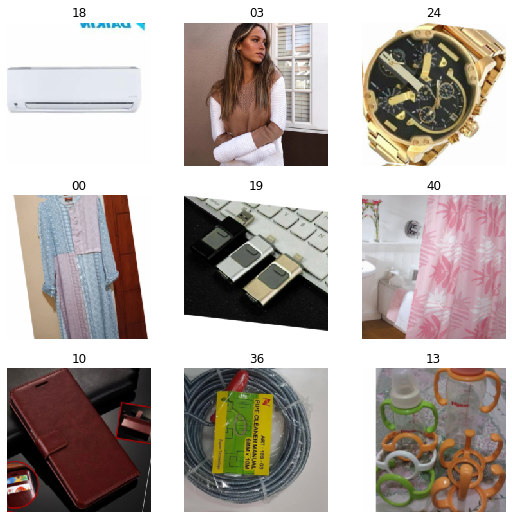

In [10]:
dls.show_batch()

In [11]:
# model darii timm itu generator, jadi create_body nya fastai harus di"modif" sesuai dengan arch-nya, dimana butuh generator.

def create_timm_body(arch:str, pretrained=True, cut=None):
    model = create_model(arch, pretrained=pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [12]:
body = create_timm_body('efficientnet_b3a', pretrained=True)

In [13]:
nf = num_features_model(nn.Sequential(*body.children())) * (2); nf # ubah 3072 input di head nya. karena setelah di concat pooling kan jadi gak tau berapa output buat classnya 

3072

In [14]:
head = create_head(nf, dls.c)
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)

In [15]:
# apply_init(model[1], nn.init.kaiming_normal_)

In [16]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=error_rate)

In [17]:
learn.freeze()
# learn.summary()

In [18]:
learn.lr_find(suggestions=True)


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.54 GiB already allocated; 4.50 MiB free; 14.74 GiB reserved in total by PyTorch)

In [ ]:
learn.fit_one_cycle(5, slice(52e-4, 17e-2))

In [ ]:
learn.save('efnet-stage1')


In [ ]:

learn.unfreeze()
learn.lr_find(suggestioin=True)


In [ ]:

learn.fit_one_cycle(5, 1e-4)

# changing to xresnet

In [ ]:
!pip install kornia -U

In [ ]:
net = xresnet50(pretrained=False, act_cls=Mish, sa=True, n_out=10) # sa -> self attention

In [ ]:
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

In [ ]:
net = convert_MP_to_blurMP(net, nn.MaxPool2d)

In [ ]:
def opt_func(ps, lr=defaults.lr): return Lookahead(RAdam(ps, lr=lr))

In [ ]:
opt_func = opt_func

In [ ]:

learn = Learner(dls, model=net, loss_func=LabelSmoothingCrossEntropy(), metrics=[top_k_accuracy, accuracy])

In [ ]:
learn.lr_find()

oh look gradient blow up. 

In [ ]:
from fastai2.test_utils import synth_learner
synth = synth_learner()
synth.fit_one_cycle(1)

In [ ]:

synth.recorder.plot_sched()

In [ ]:
synth.fit_flat_cos(1, pct_start=0.72)

In [ ]:
synth.recorder.plot_sched()

In [ ]:
learn.fit_one_cycle(5, 4e-3)